Tutorial to demonstrate running parameter estimation/model selection on an NR supernova injected signal.  Signal model is made by applying PCA to a set of supernova waveforms. The first few PCs are then linearly combined with a scale factor. (See https://arxiv.org/pdf/1202.3256.pdf)

For this example we use `PyMultiNest`, this can be installed using

conda install -c conda-forge pymultinest

(bilby- examples- gw_examples- supernova_example)

In [1]:
import bilby
import numpy as np

duration = 3
sampling_frequency = 4096

outdir = "outdir"
label = "supernova"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

np.random.seed(170801)

In [2]:
# We are going to inject a supernova waveform.  We first establish a dictionary
# of parameters that includes all of the different waveform parameters. It will
# read in a signal to inject from a txt file.

injection_parameters = dict(
    luminosity_distance=7.0,
    ra=4.6499,
    dec=-0.5063,
    geocent_time=1126259642.413,
    psi=2.659,
)

In [3]:
# Create the waveform_generator using a supernova source function
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.supernova,
    parameters=injection_parameters,
    parameter_conversion=lambda parameters: (parameters, list()),
    waveform_arguments=dict(file_path="MuellerL15_example_inj.txt"),
)

17:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.supernova
  time_domain_source_model: None
  parameter_conversion: __main__.<lambda>


In [4]:
# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).  These default to
# their design sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 1.5,
)
ifos.inject_signal(
    waveform_generator=waveform_generator,
    parameters=injection_parameters,
    raise_error=False,
)

17:29 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
17:29 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
/home/tatimoraes/anaconda3/lib/python3.10/site-packages/astropy/cosmology/funcs.py:79: OptimizeWarning: Unknown solver options: xtol
  res = minimize_scalar(f, method='Bounded', bounds=(zmin, zmax),
17:29 bilby INFO    : Injected signal in H1:
17:29 bilby INFO    :   optimal SNR = 19.65
17:29 bilby INFO    :   matched filter SNR = 18.53+0.12j
17:29 bilby INFO    :   luminosity_distance = 7.0
17:29 bilby INFO    :   ra = 4.6499
17:29 bilby INFO    :   dec = -0.5063
17:29 bilby INFO    :   geocent_time = 1126259642.413
17:29 bilby INFO    :   psi = 2.659
17:29 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
17:29 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
17:29 bilby INFO    : Injected signal in L1:
17:29 bilby INFO    :   optimal SNR = 28.31
17:29 bilby INFO    :   ma

[{'plus': array([ 1.86384802e-27+0.00000000e+00j,  4.74369809e-28+1.52407995e-27j,
         -1.46381892e-27+1.13952098e-27j, ...,
         -8.83532246e-30+1.53913130e-28j,  1.25382761e-28-2.47140607e-28j,
         -9.46062067e-29+0.00000000e+00j]),
  'cross': array([-6.22220305e-27+0.00000000e+00j, -1.98042601e-27-6.11946843e-27j,
          5.10131008e-27-3.58014767e-27j, ...,
          5.46139083e-29+4.49072662e-29j, -2.60774220e-29-9.20151288e-29j,
          7.13802185e-29+0.00000000e+00j])},
 {'plus': array([ 1.86384802e-27+0.00000000e+00j,  4.74369809e-28+1.52407995e-27j,
         -1.46381892e-27+1.13952098e-27j, ...,
         -8.83532246e-30+1.53913130e-28j,  1.25382761e-28-2.47140607e-28j,
         -9.46062067e-29+0.00000000e+00j]),
  'cross': array([-6.22220305e-27+0.00000000e+00j, -1.98042601e-27-6.11946843e-27j,
          5.10131008e-27-3.58014767e-27j, ...,
          5.46139083e-29+4.49072662e-29j, -2.60774220e-29-9.20151288e-29j,
          7.13802185e-29+0.00000000e+00j])}]

In [5]:
# read in from a file the PCs used to create the signal model.
realPCs = np.genfromtxt("SupernovaRealPCs.txt")
imagPCs = np.genfromtxt("SupernovaImagPCs.txt")

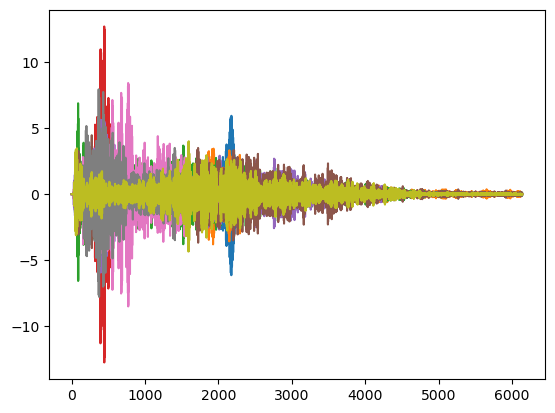

In [33]:
plt.plot(realPCs-imagPCs)

In [41]:
np.shape(realPCs)

(9,)

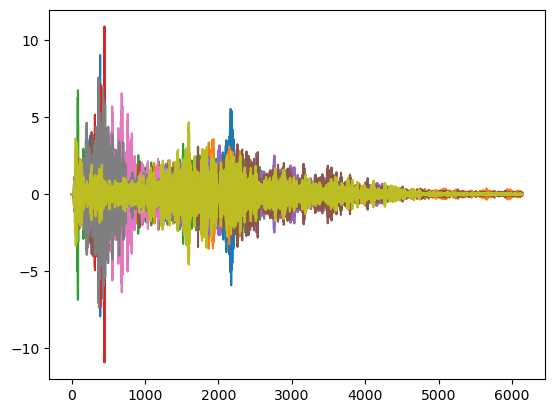

In [47]:
plt.plot(realPCs)

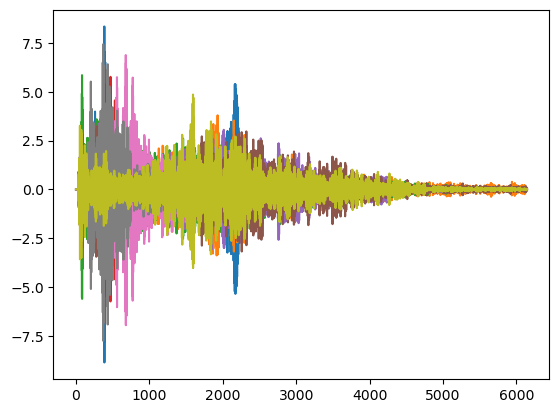

In [25]:
plt.plot(imagPCs)

In [6]:
# Now we make another waveform_generator because the signal model is
# not the same as the injection in this case.
simulation_parameters = dict(realPCs=realPCs, imagPCs=imagPCs)

search_waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.supernova_pca_model,
    waveform_arguments=simulation_parameters,
)

17:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.supernova_pca_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [7]:
# Set up prior
priors = bilby.core.prior.PriorDict()
for key in ["psi", "geocent_time"]:
    priors[key] = injection_parameters[key]
priors["luminosity_distance"] = bilby.core.prior.Uniform(
    2, 20, "luminosity_distance", unit="$kpc$"
)
priors["pc_coeff1"] = bilby.core.prior.Uniform(-1, 1, "pc_coeff1")
priors["pc_coeff2"] = bilby.core.prior.Uniform(-1, 1, "pc_coeff2")
priors["pc_coeff3"] = bilby.core.prior.Uniform(-1, 1, "pc_coeff3")
priors["pc_coeff4"] = bilby.core.prior.Uniform(-1, 1, "pc_coeff4")
priors["pc_coeff5"] = bilby.core.prior.Uniform(-1, 1, "pc_coeff5")
priors["ra"] = bilby.core.prior.Uniform(
    minimum=0, maximum=2 * np.pi, name="ra", boundary="periodic"
)
priors["dec"] = bilby.core.prior.Sine(name="dec")
priors["geocent_time"] = bilby.core.prior.Uniform(
    injection_parameters["geocent_time"] - 1,
    injection_parameters["geocent_time"] + 1,
    "geocent_time",
    unit="$s$",
)

In [8]:
# Initialise the likelihood by passing in the interferometer data (IFOs) and
# the waveoform generator
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=search_waveform_generator
)

In [9]:
# Run sampler.
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="pymultinest",
    npoints=500,
    outdir=outdir,
    label=label,
)

17:29 bilby INFO    : Running for label 'supernova', output will be saved to 'outdir'
17:29 bilby INFO    : Using lal version 7.3.1
17:29 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.18;Id: 92efdb05800b9cde3ef6d44e396fc19775168424;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
17:29 bilby INFO    : Using lalsimulation version 5.2.1
17:29 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.18;Id: 92efdb05800b9cde3ef6d44e396fc19775168424;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
17:30 bilby INFO    : Analysis priors:
17:30 bilby INFO    : geocent_time=Uniform(minimum=1126259641.413, maximum=1126259643.413, name='geocent_time', latex_label='$t_c$', unit='$s$', boundary=None)
17:30 bilby INFO    : luminosity_distance=Uniform(minimum=2, maximum=20, name='luminosity_distance', latex_label='$d_L$', unit='$kpc$', boundary=None)
17:30 bilby INFO    : pc_coeff1=Uniform(minimum=-1, maxi

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    9
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.078781
Replacements:                              15285
Total Samples:                            194018
Nested Sampling ln(Z):                101.103019


17:30 bilby INFO    : Overwriting outdir/pm_supernova/ with /tmp/tmpt2glrdd7/
17:30 bilby INFO    : Overwriting outdir/pm_supernova/ with /tmp/tmpt2glrdd7/


  analysing data from /tmp/tmpt2glrdd7/.txt
 ln(ev)=   101.26199826265879      +/-  0.22540106683129613     
 Total Likelihood Evaluations:       194018
 Sampling finished. Exiting MultiNest


17:30 bilby INFO    : Sampling time: 0:07:11.843285
17:30 bilby INFO    : Summary of results:
nsamples: 2216
ln_noise_evidence: -12720.186
ln_evidence: -12618.924 +/-  0.225
ln_bayes_factor: 101.262 +/-  0.225



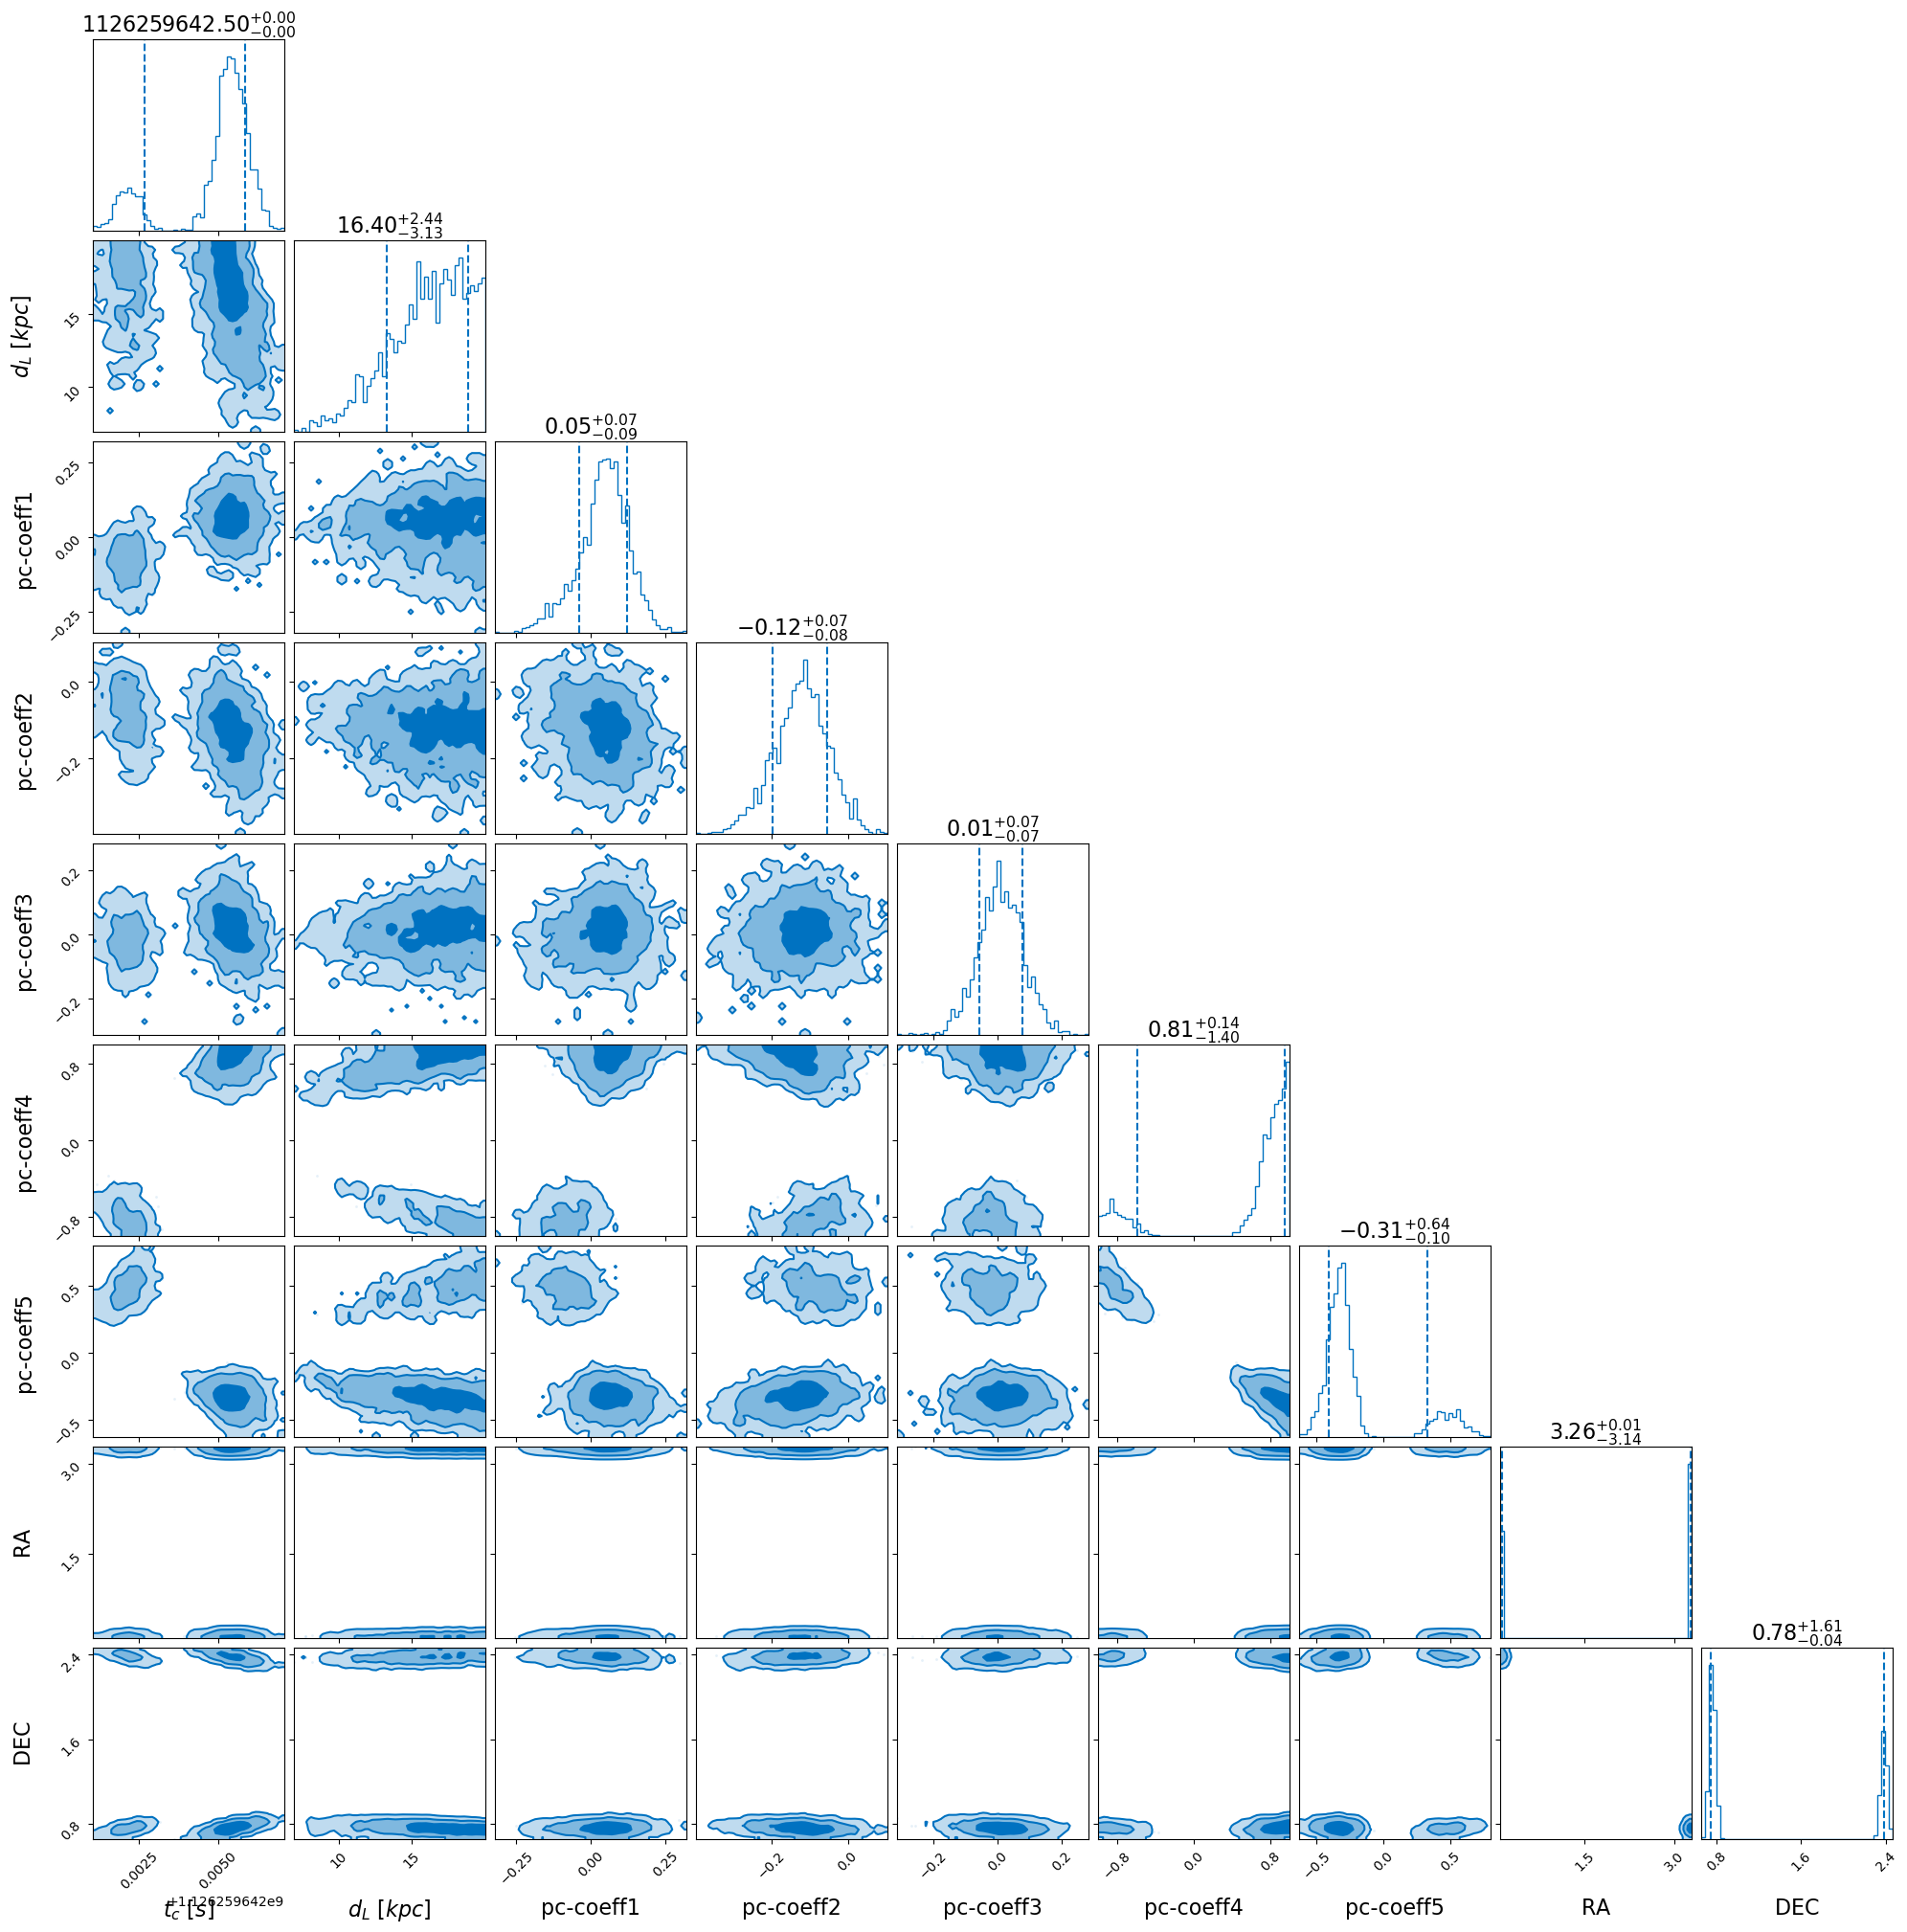

In [10]:
# make some plots of the outputs
result.plot_corner()